# Barske Pump Design

> Author: Craig Orrock (assisted by Elias Aoubala)

> Date: 24/05/2025

In [1]:
import numpy as np
from turborocket.sizing.pump import Barske, DiffuserType
from turborocket.fluids.fluids import IncompressibleFluid
import matplotlib.pyplot as plt

import handcalcs.render

## 1 - Background

This document contains the sizing of the Barske Impeller pump using the turborocket pump class built by `Craig Orrock`.

## 2 - High Level Performance Metrics and Assumptions

Below, a dictionary of the high level performance metrics for the pump has been presented. The design methodology follows the recommendations presented by `U.M. Barske` in his publication `The Design of Open Impeller Centrifugal Pumps`.

A standard flat sided impeller has been assumed for the present geometry, moreover a rectangular diffuser is intended to be used.

Given the small flow rates we will be dealing, inorder for the pump geometry to be feasible to manufacture, the pump will be sized for a larger than required mass flow rate with a recirculation valve used to recirculate any excess mass flow back round to the inlet of the pump.

A diagram has been presented below of what the architecture would look like:

```mermaid
flowchart LR

    inlet("Inlet") --> JN1{"Junction 1"}
    JN1 --> pump["Barske Pump"]

    pump --> JN2{"Junction 2"}

    JN2 --> engine(["Main Engine"])

    JN2 --> GG(["Gas Generator"])

    JN2 --> valve{{"Needle Valve 1"}}

    valve --> JN1

```

Now there are four key things that drive the sizing of the pump and the needle valve:

- COTS component availability for the needle valve
- Gas Generator Sizing for the required pump power
- Main Engine Expected Propellant Flow Ranges for the Pump
- Required **Operational Run-Time**.

The first three problems are relatively easy to resolve, however the last of the three is most problematic as doing the recirculation loop will result in a rise in temperature over time of the propellant entering the pump which could eventually result in a cavitation event.

Thus, it is critical to understand what the expected temperature rise would be by implementing this recirculation valve accordingly and evaluate what the expected impact would be on system performance.

### 2.1 - Recirculation Temperature Increase Rate

For evaluating the Temperature Increase Rate of the pump, we need to firstly evaluate for what the waste-power is relative to the flow rate which could generate heat.

We know that the hydraulic efficiency of a pump can be defined as follows:

$$\eta = \frac{P_{a}}{P_{theo}}$$

Where $P_a$ refers to the actual hydraulic power of the pump and $P_{theo}$ refers to the theoretical power of the pump. We can take the conservative assumption and assume that all the "lost" power is imparted as heat directy into the fluid, resulting in a temperature rise accordingly.

Hence we can define the thermal power added to the fluid as follows:

$$P_{th} = P_{theo} - P_{a}$$

$$P_{th} = P_{theo}(1 - \eta)$$

The temperature rise in a fluid caused by an addition of thermal energy is as follows:

$$E = m c_p \Delta T$$

We can convert this to a time dependent form by differentiating with respect to time to get the following:

$$P_{th} = \dot{m} c_p \Delta T$$

This will now give us an idea of the temperature rise that results from the efficiency losses of the impeller.

We must now also account for the mixing of propellant at the inlet of the pump between the recirculated fluid and the delivered fluid from the test-house using a conservation of energy approach to get the following:

$$T_f = \frac{\dot{m}_1 T_1 + \dot{m}_2 T_2}{\dot{m}_1 + \dot{m}_2}$$

$$T_f = \frac{\dot{m}_1 T_1 + \dot{m}_2 T_2}{\dot{m}_{pump}}$$

We can introduce a "recirculation factor" to get the following:

$$T_f = (1- \chi)T_1 + \chi T_2$$

Where $\chi$ refers to the percentage of the total pump flow that is recirculated back into the pump inlet.

Remembering T_2 is just the previous temperature time step with the addition of the thermal energy, we get the following:

$$T_{i} = (1- \chi)T_1 + \chi (T_{i-1} + \Delta T)$$

Which if we substitude our parameters, we can get the following

$$T_{i} = (1- \chi)T_1 + \chi (T_{i-1} + \frac{P_{theo}(1 - \eta)}{\dot{m}_{pump} c_p} )$$

We can also substitude our definition for the theoretical power produced by the pump as follows:

$$P_{theo} = Q \Delta P = \frac{\dot{m}_{pump}}{\rho} \Delta P$$

This gives us the following expression:

$$T_{i} = (1- \chi)T_1 + \chi (T_{i-1} + \frac{\Delta P(1 - \eta)}{\rho c_p} )$$

This will result in the following equation

$$T(t) = T_{steady} + (T_{o} - T_{steady}) e^{- \frac{\dot{m}_i}{m} t}$$

Where the steady temperature is defined as the following

$$T_{steady} = T_{in} + \frac{\Delta P(1 - \eta)}{\chi \rho c_p}$$

We now have a simple equation we can integrate over time to see what our temperature rise would be for a given dp and efficiency. For this analysis, a conservative value of 10% will be assumed on efficiency.

m_dot_v: 233.15 g/s
0.09868028579424937
0.1427427857942494
0.18680528579424938
0.23086778579424933
0.2749302857942494


Text(0.5, 1.0, 'Temperature History of System using a Valve w/ C_v: 0.18')

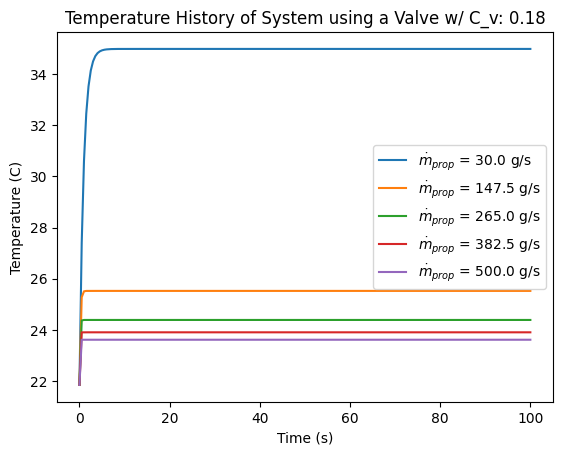

In [2]:
N_1 = 5
N_2 = 200
dt = 0.1

m_dot_array = np.linspace(0.03,0.5,N_1)

t_arrary = np.linspace(0,100, N_2)

T_history = np.zeros([N_1, N_2])

tau = 1

# For our systems thermal inertia, we will consider the volume in the volute of the impller + 30 cm 1/2 in line.
V = 20e-2 * np.pi * (10e-3/2)**2 + (np.pi * ((7e-2)/2)**2)*5e-3

cp = 2.68e3
rho = 786
rho_water = 1000
dp = 35e5

# Pump Parameters
m_dot_design = 0.8
eta_design = 0.3

N_1 = 8.65e-2
c_v = 0.37/2

Q = (N_1 * c_v * ((dp/1e3)/(rho/rho_water))**(1/2)) / (60*60)
m_dot_v = Q * rho

print(f"m_dot_v: {m_dot_v*1e3:.2f} g/s")
T_in = 295
T_o = T_in

for index, i in np.ndenumerate(m_dot_array):

    m_dot_draw = m_dot_array[index]

    tau = (V * rho) / (m_dot_v + m_dot_draw)

    chi = m_dot_draw/(m_dot_v + m_dot_draw)

    eta = ((m_dot_v + m_dot_draw)/m_dot_design) * eta_design

    print(eta)

    T_steady = T_in + (dp * (1 - eta))/(chi * rho * cp)

    temp_hist = T_steady + (T_o - T_steady)* np.exp(-chi*t_arrary/tau)

    plt.plot(t_arrary, temp_hist- 273.15, label=r"$\dot{m}_{prop}$ = " + f"{m_dot_draw*1e3:.1f} g/s")

plt.xlabel("Time (s)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.title(f"Temperature History of System using a Valve w/ C_v: {c_v:.2f}")

We can now compare this to the expected vapour pressures of IPA as a function of temperature which was found [Here]([Here](https://en.wikipedia.org/wiki/Isopropyl_alcohol_%28data_page%29#/media/File:Isopropanol_Vapor_Pressure.tif))

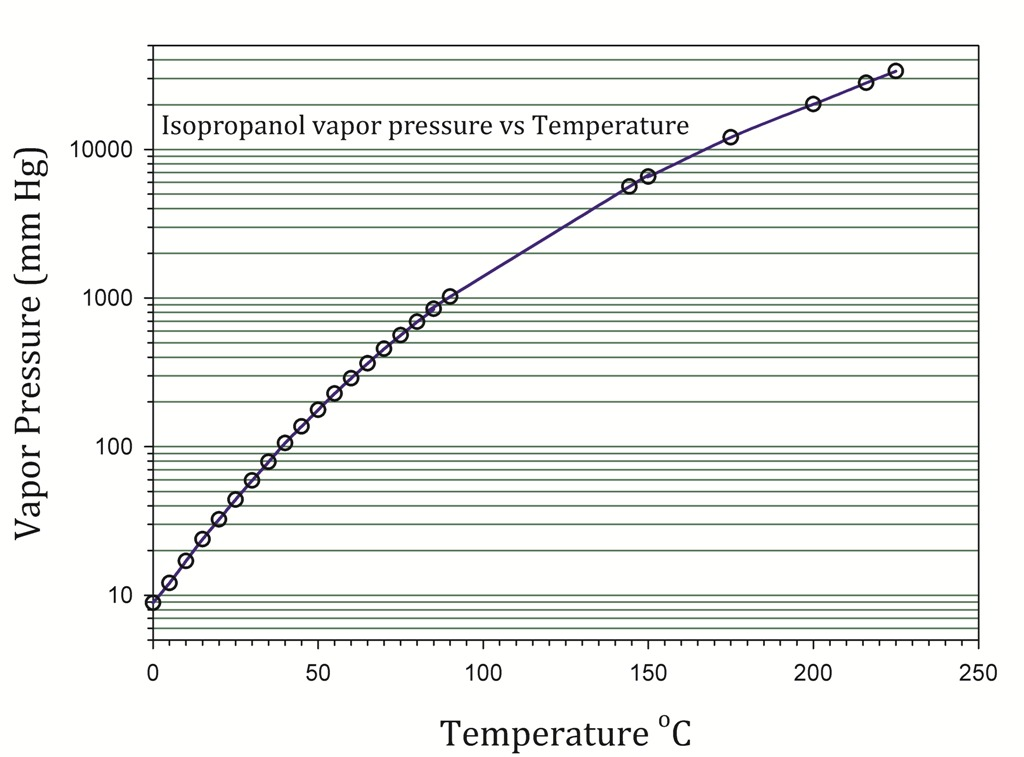

If we even take the value for 100 C, we can see that the vapour pressure ends up being 1000 mm Hg (1.33 Bar), which is way above the expected pressures we will be operating at. Hence this was considered acceptable.

### 2.2 - Required Performance Metrics

In [10]:
pump_dic = {
    "dp": 25e5,
    "m_dot": 0.8,
    "N": 24e3 * (2*np.pi)/60
}

A definition of the IPA fluid has been presented below:

In [11]:
IPA = IncompressibleFluid(rho=787, P=20e5, mue=2.37e-3)

The following geometric parameters and performance assumptions have been used:

In [12]:
pump_geo = {
    "fluid": IPA,
    "l_1": 10e-3,
    "l_2": 5e-3,
    "v_0": 3,
    "v_3f": 0.61,
    "d_1f": 1.2,
    "a_3f": 3.5,
    "delta_div": 8,
    "diffuser_type": DiffuserType.rectangular,
    "psi": 0.2,
}

We can also evaluate for our specific speed of the pump to compare it to others of similar geometry

In [13]:
M3S_TO_GPM = 15850.323140625
g = 9.81
M_TO_FT = 3.28084

In [14]:
%%render

Q = (pump_dic["m_dot"]/pump_geo["fluid"].get_density()) * M3S_TO_GPM # gpm

H = pump_dic["dp"]/(pump_geo["fluid"].get_density() * g) * M_TO_FT # ft

N = pump_dic["N"] * 60/(2*np.pi) # rpm

N_s = (N * (Q) ** (1 / 2)) / H ** (0.75)

<IPython.core.display.Latex object>

## 3 - Calculated Geometry

Below a list of the key geometric parameters for the pump has been derived.

In [15]:
pump = Barske(**pump_dic)

pump.size_pump(**pump_geo)

,Eye Diameter - d_0 (mm),Inlet Diameter - d_1 (mm),Exit Diameter - d_2 (mm),Entrance Axial Blade Length - l_1 (mm),Exit Axial Blade Legnth - l_2 (mm),Axial Clearance - c_1 (mm),Radial Clearance - c_2 (mm),Diffuser Type,Diffuser Throat - d_3 (mm),Diffuser Exit - d_4 (mm),Diffuser Length - L (mm),Inlet Eye Velocity - v_o (m/s),Impeller Inlet Velocity - v_1 (m/s),Relative Exit Velocity - w_2 (m/s)
0,20.770744,24.924893,62.212583,10.0,5.0,0.622126,3.110629,DiffuserType.rectangular,4.263118,14.920912,75.834145,3,1.298172,1.040201


Finally, this is the expected performance metrics of the pump

In [9]:
pump.get_pump_performance(fluid=pump_geo["fluid"], m_dot=pump_dic["m_dot"], psi=0.2, N=pump_dic["N"])

,Head Rise (m),Head Rise (Bar),Efficiency (%),Hydraulic Power (kW),Required Shaft Power (kW)
0,323.814483,25.0,37.548999,3.494282,9.305926
